
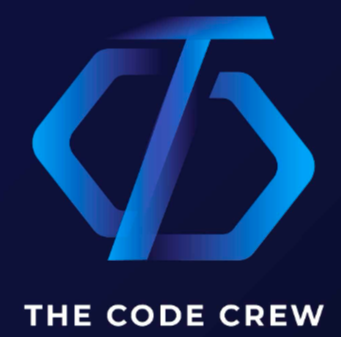


Important Dataframes and files:

- owid-covid-data.csv:This file located in the folder resources contains all the COVID Data downloaded from 
                              <a href="https://github.com/owid/covid-19-data/tree/master/public/data "> Our World in Data </a> 
- clean_covid_data:         Contains only the columns we thing we need from the covid data source csv file
- clean_covid_data_no_date: Similar to clean_covid_data. The Date in this DF now is group by Month and Year and by Country  
- df_clean_data:                 
- gdp_by_year: Iso of the countries and GDP for 2019, 2020, 221    
- covid_and_gdp: Contains a merge between gdp_by_year,df_clean_data on the ISO country

In [ ]:
# Dependencies
from census import Census
import hvplot.pandas
import pandas as pd
import requests
import time
from scipy.stats import linregress
from matplotlib import pyplot as plt
import wbdata


# Turn off warning messages
import warnings
warnings.filterwarnings("ignore")





In [ ]:
# Importing data from Stats Canada
csv_url = "Resources/owid-covid-data.csv"
covid_data = pd.read_csv(csv_url)
covid_data.columns


In [ ]:
# Filtering DataFrame by columns of interest
clean_covid_data = covid_data.loc[covid_data['iso_code'].str.contains('OWID_')==False, ['iso_code', 'location', 'date', 'new_cases',  'new_deaths',  'new_cases_per_million',  'new_deaths_per_million',
                                      'icu_patients',
                                      'icu_patients_per_million', 'hosp_patients_per_million', 'new_tests_per_thousand',
                                      'positive_rate', 'people_vaccinated_per_hundred',
                                      'people_fully_vaccinated_per_hundred', 'stringency_index',
                                      'population_density', 'median_age',
                                      'gdp_per_capita', 'extreme_poverty', 'human_development_index', 'population']]


# Creating a list of columns to sum and calculate mean

sum_columns_list = ['new_cases',  'new_deaths',
                    'new_cases_per_million',  'new_deaths_per_million']
mean_columns_list = ['icu_patients','icu_patients_per_million','hosp_patients_per_million']                              

# Converting NaN to 0
clean_covid_data = clean_covid_data.fillna(0)

# Display DF
clean_covid_data.head(10)


In [ ]:

# Creating a new column for Month-Year
clean_covid_data.insert(3,"month_year",pd.to_datetime(clean_covid_data['date']).dt.to_period('M') )
clean_covid_data_no_date = clean_covid_data.drop('date',axis = 1)

# Display DF
clean_covid_data_no_date.head(10)

In [ ]:
iso_codes = clean_covid_data_no_date['iso_code'].unique()
iso_codes

In [ ]:
# Creating a DataFrame grouping by Month-Year and Country and adding the columns for sums and average

df_sum = clean_covid_data_no_date.groupby(['iso_code', 'month_year'])[
    sum_columns_list].sum()



df_sum = df_sum.rename(columns={"new_cases":"sum_new_cases",'new_deaths':'sum_new_deaths', 'new_cases_per_million': 'sum_new_cases_per_million'\
                        , 'new_deaths_per_million': 'sum_new_deaths_per_million' })
                      

df_mean = clean_covid_data_no_date.groupby(['iso_code', 'month_year'])[
    mean_columns_list].mean()


df_mean = df_mean.rename(columns={'icu_patients': 'average_icu_patients',
                    'icu_patients_per_million': 'average_icu_patients_per_million','hosp_patients_per_million':'average_hosp_patients_per_million'})


df_clean_data = pd.merge(df_sum, df_mean, on=['iso_code', 'month_year'])

df_clean_data



In [ ]:
# Create a DataFrame for Static Columns
totals_list=['stringency_index','population_density', 'median_age',
                                      'gdp_per_capita', 'extreme_poverty', 'human_development_index', 'population']
df_totals = clean_covid_data_no_date.groupby(
    ['iso_code'])[totals_list].mean()

# Converting population to Int
df_totals['population'] = df_totals['population'].astype(int)

df_totals


In [ ]:
wbdata.getGdpData()

In [ ]:
# Creating dataframe from World Bank API JSON
gdp = wbdata.getGdpData()
gdp = [entry for entry in gdp if int(entry['date']) > 2018]
gdp_df = pd.DataFrame.from_dict(gdp)
gdp_by_year = gdp_df[['countryiso3code', 'date', 'value']]
gdp_by_year = gdp_by_year.rename(columns={'countryiso3code': 'iso_code'})

# Fillining NaN with 0
gdp_by_year = gdp_by_year.fillna(0)

# Using .pivot_table
gdp_by_year = gdp_by_year.pivot_table(
    values='value', index='iso_code', columns='date', aggfunc='first')

gdp_by_year = gdp_by_year.reset_index()

gdp_by_year = gdp_by_year[gdp_by_year['iso_code'].isin(iso_codes)]

print(gdp_by_year)

gdp_2019 = gdp_by_year.loc[:,['iso_code', '2019']]
gdp_2019 = gdp_2019.loc[gdp_2019['2019']>0]
# gdp_2019 = gdp_2019.drop(index=0)


gdp_head = gdp_2019.sort_values(by='2019').head()
gdp_tail = gdp_2019.sort_values(by='2019').tail()


## Make this into a function to calculate other years


# gdp_tail


In [ ]:
## Combining Covid Data and world bank GDP 


covid_and_gdp= pd.merge(gdp_by_year,df_clean_data, how='outer', on='iso_code')

covid_and_gdp.to_csv("covid_and_gdp.csv")

covid_and_gdp


